# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 4: Missing Data and Principal Component Analysis (PCA)


**Harvard University**<br/>
**Fall 2021**<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai

---

In [1]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

<a id="instructions"></a>

<hr style="height:2pt">

### INSTRUCTIONS


- To submit your assignment follow the instructions given in Canvas.

- Please **restart the kernel and run the entire notebook again before you submit.**

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code continues to work, restart the kernel and rerun your notebook periodically while working through this assignment. 

- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. **Please use only the libraries provided in those imports.**

- Please use `.head(...)` when viewing data. Do not submit a notebook that is **excessively long**. 

- In questions that require code to answer, such as "calculate and report $R^2$", do not just output the value from a cell. Write a `print(...)` function that clearly labels the output, includes a reference to the calculated value, and rounds it to a reasonable number of digits. **Do not hard code values in your printed output**. For example, this is an appropriate print statement:
```python
print(f'The R^2 is {R:.4f}')
```
- **Your plots MUST be clearly labeled and easy to read,** including clear labels for the $x$ and $y$ axes, a descriptive title ("MSE plot" is NOT a descriptive title; "95% confidence interval of coefficients for degree-5 polynomial model" on the other hand is descriptive), a legend when appropriate, and clearly formatted text and graphics.

- **Your code may also be evaluated for efficiency and clarity.** As a result, correct output is not always sufficient for full credit.

<hr style="height:2pt">

### Import Libraries

In [2]:
# RUN THIS CELL

# Import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer, KNNImputer

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

%matplotlib inline

<a id="contents"></a>

## Notebook contents

- [**PART 1 [55 pts]: Predicting the selling price of used cars**](#part1)
  - [Overview and Data Description](#part1intro)
  - [Question 1: Visualizing Missing Data [10 pts]](#part1q1)
      - [Solutions](#part1q1solution)
  - [Question 2: Imputation Methods [45 pts]](#part1q2)
      - [Solutions](#part1q2solution)


- [**PART 2 [45 pts]: Principal Componant Analysis**](#part2)
  - [Question 3: PCA for Regression [35 pts]](#part2q3)
      - [Solutions](#part2q3solution)
  - [Question 4: Visualizing Transformed Data [10 pts]](#part2q4)
      - [Solutions](#part2q4solution)


<a id="part1"></a>
    
# PART 1 [55 pts]: Predicting the selling price of used cars

[Return to contents](#contents)

<a id="part1intro"></a>

## Overview and Data Description 

[Return to contents](#contents)

In this part, we analyze the data about used cars from a [Kaggle project](https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho). The dataset is pre-processed and modified so that it contains missing values. The goal is to handle missing data and predict selling prices from the other features available in this dataset.

### Dataset 

The training dataset is available as `data/vehicle_dataset_train.csv`. It contains the following columns:

- `year` - year of the car when it was bought, 
- `mileage` - mileage of the car,
- `max_power` - maximum power of the engine (in bhps),
- `selling_price` - price at which the car is being sold (in lakh rupees)

The testing dataset is available as `data/vehicle_dataset_test.csv`. It contains all columns mentioned above.


### Objective

We will handle missing data and predict `selling_price` from the other features available in this dataset.

<a id="part1q1"></a>

## <div class='exercise'><b>Question 1: Visualizing Missing Data [10 pts]</b></div>

[Return to contents](#contents)


**Load the dataset, inspect it, and answer the following questions:**


**1.1** How many columns and which ones include missing data in **X_train**? In each of those columns, how many observations are missing?

**1.2** Plot a boxplot of `year` for all samples that contain missing values. In the same plot, generate another boxplot of `year` for all samples that do not contain missing values. Do you see any pattern?  If so, what might be the implications of that pattern?
    
    
**PLEASE NOTE:** In this course, you will be expected to ALWAYS label your axes, title your graphs, and produce visuals which clearly communicate the data (as described in the [Instructions](#instructions) at the start of this notebook). Visuals should often be accompanied by text identifying the key point of the visual and defending any choices you make as a data scientist regarding the visual to best communicate your data.

<a id="part1q1solution"></a>
## Question 1: Solutions 

[Return to contents](#contents)

In [3]:
# Load the datasets
df_train = pd.read_csv("data/vehicle_dataset_train.csv", index_col=0)
df_test = pd.read_csv("data/vehicle_dataset_test.csv", index_col=0)
df_train.head(5)

,year,mileage,max_power,selling_price
6601,2015,17.40,117.30,70.0
504,2017,13.60,NaN,262.5
5812,2018,24.00,73.97,71.0
1443,2009,19.70,46.30,15.0
7453,2014,16.02,NaN,42.5


In [4]:
X_train, y_train = df_train.drop(columns=['selling_price']), df_train['selling_price']
X_test, y_test = df_test.drop(columns=['selling_price']), df_test['selling_price']

<div class='exercise-r'>

**1.1** How many columns and which ones include missing data in **X_train**? In each of those columns, how many observations are missing?
</div> 

In [5]:
# your code here
print("There are a total of ", len(X_train.columns), " columns in X_train")

print("Below we can see which columns are missing data.")
print("The number of observations that are missing from each column is: ")
X_train.isna().sum()

There are a total of  3  columns in X_train
Below we can see which columns are missing data.
The number of observations that are missing from each column is: 


year          0
mileage       0
max_power    44
dtype: int64

<div class='exercise-r'>

**1.2** Generate a boxplot of `year` for all samples that have missing values. In the same plot, generate another boxplot of `year` for all samples that do not have missing values. Do you see any pattern?  If so, what might be the implications of that pattern? 

</div> 

Text(0.5, 1.0, 'Analysis of Year with Missing Data vs Not Missing Value')

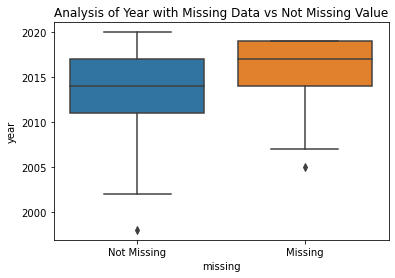

In [6]:
# your code here
X_train_missing = X_train.copy()
X_train_missing['missing'] = np.where(X_train_missing.max_power.isnull(), 'Missing', 'Not Missing')

sns.boxplot(x=X_train_missing['missing'], y=X_train_missing['year'])
plt.title("Analysis of Year with Missing Data vs Not Missing Value")

**INTERPRETATION:**

**The mean on average for Not Missing Data appears to be lower than the mean for Missing Data. It is unclear if this difference is statistically significant. If we just drop the rows with missing data, this will skew our model as we will drop data from higher years.**

<a id="part1q2"></a>

## <div class='exercise'><b> Question 2:   Imputation Methods [45 pts]</b></div>

[Return to contents](#contents)

We will try different ways of dealing with missing data.

**2.1** First, we consider mean imputation:
  - Use SimpleImputer to impute the mean of observed `max_power` values in the training dataset for both **X_train** and **X_test**. 
  - Fit a linear regression model and a k-NN regression model ($k$=2) on the training data. 
  - Report the $R^2$ values on the testing data for each of your two fitted models.

**2.2** Now, we will impute the data using k-NN regression model and see how it works:
  - Use KNNImputer ($k$=2) to impute both **X_train** and **X_test**.
  - Fit a linear regression model and a k-NN regression model ($k$=2) on the training data. 
  - Report the $R^2$ values on the testing data for each of your two fitted models.

**2.3** Now, let's examine the indicator method:
  - For both the training and testing data, create an additional predictor called `has_missing_value` that indicates
   whether each row has any missing value. Impute the mean of observed `max_power` values in the training dataset for both **X_train** and **X_test**.
  - Fit a linear regression model and a k-NN regression model ($k$=2) on the training data. 
  - Report the $R^2$ values on the testing data for each of your two fitted models.


**2.4** Discuss your results by answering the following questions.  You should answer the questions directly in the provided markdown cells of your notebook.

- **2.4.1** Which method results in the largest $R^2$ value? Interpret your findings.

- **2.4.2** Compare the $R^2$ values in **2.1** and **2.3**. Does adding an indicator variable help? Do these indicator method results provide any support **for** or **against** a claim that the data is missing completely at random?  Why or why not?


<a id="part1q2solution"></a>
## Question 2: Solutions 

[Return to contents](#contents)

<div class='exercise-r'>

    

**2.1** First, we consider mean imputation:
  - Use SimpleImputer to impute the mean of observed `max_power` values in the training dataset for both **X_train** and **X_test**. 
  - Fit a linear regression model and a k-NN regression model ($k$=2) on the training data. 
  - Report the $R^2$ values on the testing data for each of your two fitted models.

    
</div>

In [7]:
# your code here
X_train_simple = X_train.copy()
X_test_simple = X_test.copy()

# instantiate imputer objects
imputer_train = SimpleImputer()
imputer_test = SimpleImputer()

# fit & transform X_train and X_test with the imputer
imputer_train.fit(X_train_simple)
X_train_simple = imputer_train.transform(X_train_simple)

imputer_test.fit(X_test_simple)
X_test_simple = imputer_test.transform(X_test_simple)

# fit linear model on imputed data
lreg = LinearRegression()
lreg.fit(X_train_simple, y_train)
y_linear_pred = lreg.predict(X_test_simple)

# fit knn model on imputed data
knn_model = KNeighborsRegressor(n_neighbors=2)
knn_model.fit(X_train_simple, y_train)
y_knn_pred = knn_model.predict(X_test_simple)

# Report R2 values
print(f"The R2 score of the linear model is {r2_score(y_test, y_linear_pred)}")
print(f"The R2 score of the k-NN model is {r2_score(y_test, y_knn_pred)}")

The R2 score of the linear model is 0.18925114763198259
The R2 score of the k-NN model is 0.6971846260429062


<div class='exercise-r'>

**2.2** Now, we will impute the data using k-NN regression model and see how it works:
  - Use KNNImputer ($k$=2) to impute both **X_train** and **X_test**.
  - Fit a linear regression model and a k-NN regression model ($k$=2) on the training data. 
  - Report the $R^2$ values on the testing data for each of your two fitted models.
    
</div>

In [8]:
# your code here
X_train_knn = X_train.copy()
X_test_knn = X_test.copy()

# fit & transform X_train and X_test with the imputer
X_train_knn = KNNImputer(n_neighbors=2).fit_transform(X_train_knn)

X_test_knn = KNNImputer(n_neighbors=2).fit_transform(X_test_knn)

# fit linear model on imputed data
lreg = LinearRegression()
lreg.fit(X_train_knn, y_train)
y_linear_pred = lreg.predict(X_test_knn)

# fit knn model on imputed data
knn_model = KNeighborsRegressor(n_neighbors=2)
knn_model.fit(X_train_knn, y_train)
y_knn_pred = knn_model.predict(X_test_knn)

# Report R2 values
print(f"The R2 score of the linear model is {r2_score(y_test, y_linear_pred)}")
print(f"The R2 score of the k-NN model is {r2_score(y_test, y_knn_pred)}")

The R2 score of the linear model is 0.2051794804748054
The R2 score of the k-NN model is 0.30513381817903795


<div class='exercise-r'>

    
**2.3** Now, let's examine the indicator method:
  - For both the training and testing data, create an additional predictor called `has_missing_value` that indicates
   whether each row has any missing value. Impute the mean of observed `max_power` values in the training dataset for both **X_train** and **X_test**.
  - Fit a linear regression model and a k-NN regression model ($k$=2) on the training data. 
  - Report the $R^2$ values on the testing data for each of your two fitted models.
    
</div>

In [9]:
# your code here
X_train['has_missing_value'] = np.where(X_train.max_power.isnull(), 0, 1)
X_test['has_missing_value'] = np.where(X_test.max_power.isnull(), 0, 1)

X_train_simple = X_train.copy()
X_test_simple = X_test.copy()

# instantiate imputer objects
imputer_train = SimpleImputer()
imputer_test = SimpleImputer()

# fit & transform X_train and X_test with the imputer
imputer_train.fit(X_train_simple)
X_train_simple = imputer_train.transform(X_train_simple)

imputer_test.fit(X_test_simple)
X_test_simple = imputer_test.transform(X_test_simple)

# fit linear model on imputed data
lreg = LinearRegression()
lreg.fit(X_train_simple, y_train)
y_linear_pred = lreg.predict(X_test_simple)

# fit knn model on imputed data
knn_model = KNeighborsRegressor(n_neighbors=2)
knn_model.fit(X_train_simple, y_train)
y_knn_pred = knn_model.predict(X_test_simple)

# Report R2 values
print(f"The R2 score of the linear model is {r2_score(y_test, y_linear_pred)}")
print(f"The R2 score of the k-NN model is {r2_score(y_test, y_knn_pred)}")

The R2 score of the linear model is 0.395336055512156
The R2 score of the k-NN model is 0.7249133405431436


<div class='exercise-r'>
    

**2.4.1** Which method results in the largest $R^2$ value? Interpret your findings.

</div>

**The indicator imputation method, with a fitted kNN model results in the largest R2 value. This is because it allows the model to differentiate between real data and imputed data, which gives it better predictive ability. The kNN model is the best most likely because X and y are not linear.**


<div class='exercise-r'>

**2.4.2** Compare the $R^2$ values in **2.1** and **2.3**. Does adding an indicator variable help? Do these indicator method results provide any support **for** or **against** a claim that the data is missing completely at random? Why or why not?
    
</div>

**Yes, adding the indicator variable helps. This does not support the claim that the data is missing completely at random, since adding a missing indicator variable improves the predictive power of the model.**


<a id="part2"></a>
    
# PART 2 [45 pts]: Principal Component Analysis

[Return to contents](#contents)

<a id="part2q3"></a>

## <div class='exercise'><b> Question 3: PCA for Regression [35 pts]</b></div>

[Return to contents](#contents)
 

In this question, we will be using a dataset called "Communities and Crime" adapted from [UC Irvine Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Communities+and+Crime). The modified dataset contains 122 predictor variables and 1 response variable. All numeric data was normalized into the decimal range 0.00-1.00. Some of the predictor variables are:

- `householdsize`: mean people per household
- `medIncome`: median household income
- `PctHousOccup`: percent of housing occupied
- `RentMedian`: rental housing - median rent
- `PolicReqPerOffic`: total requests for police per police officer

And the response variable is 

- `ViolentCrimesPerPop`: total number of violent crimes per 100K popuation



**Load the dataset, split it in training (80%) and test set (20%), inspect it, and answer the following questions:**


**3.1**  Compute the correlation matrix for the predictor variables in the training data (DO NOT print the entire matrix). Which pairs of distinct predictor variables have correlation greater than 0.99 or less than -0.99? (Output only those pairs with the corresponding correlation.)

**3.2** Fit a linear regression model on the training data **using all available predictors**. Report and interpret the $R^2$ value on the testing data.


**3.3** Now let's consider PCA for regression:
  - **3.3.1** Standardize both **X_train** and **X_test** and for each number of components $k$ in $k \in \{1,2,3,4,5,6,8,10,12,15,20\}$: 
  
      - Fit the PCA transformation with n_components = $k$ on the standardized **X_train**.
     
      - Apply the PCA transformation to the standardized **X_train**.   
      
     - Use scikit-learn's cross_validate(...) to perform a 10-fold cross validation for a linear regression model on the transformed training data. 
   
    Plot the mean validation MSE for each $k$. Report the best $k$ based on the mean validation MSE.
          
        
  - **3.3.2** Now let's compute the $R^2$ value on the testing data:
    - Fit the PCA transformation with n_components equals the best $k$ on the standardized **X_train**.
    - Apply the PCA transformation to both the standardized **X_train** and the standardized **X_test**. 
    - Fit a linear regression model to the PCA-transformed components and report the  test $R^2$.
    
**3.4** Compare the $R^2$ value obtained from **3.2** and **3.3.2**. Interpret the result.

In [10]:
# Load the datasets
df = pd.read_csv("data/communities_and_crime.csv", index_col = 0)
df.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,...,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.00,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,...,0.96,0.17,0.06,0.18,0.44,0.13,0.94,0.93,0.03,0.07,0.10,0.07,0.02,0.57,0.29,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14,0.20
1,0.15,0.31,0.40,0.63,0.14,0.06,0.58,0.72,0.65,0.47,0.16,1.00,0.22,0.52,0.10,0.51,0.48,0.39,0.51,0.30,0.29,0.34,0.23,0.13,0.20,...,0.93,0.38,0.05,0.21,0.23,0.30,0.61,0.89,0.15,0.01,0.06,0.12,0.10,0.64,0.22,0.06,0.39,0.84,0.06,0.06,0.91,0.5,0.88,0.26,0.49
2,0.25,0.54,0.05,0.71,0.48,0.30,0.42,0.48,0.28,0.32,0.26,1.00,0.33,0.55,0.37,0.37,0.39,0.64,0.44,0.32,0.29,0.32,0.23,0.17,0.17,...,0.96,0.12,0.05,0.11,0.35,0.08,0.80,0.82,0.04,0.19,0.19,0.18,0.05,0.57,0.36,0.09,0.46,0.05,0.09,0.05,0.88,0.5,0.76,0.13,0.34
3,1.00,0.42,0.47,0.59,0.12,0.05,0.41,0.53,0.34,0.33,1.00,0.99,0.28,0.62,0.16,0.36,0.40,0.30,0.45,0.29,0.30,0.35,0.21,0.20,0.33,...,0.75,0.19,0.35,0.19,0.38,0.16,0.82,0.70,0.45,0.03,0.05,0.33,0.13,0.57,1.00,1.00,0.07,0.15,1.00,0.35,0.73,0.0,0.31,0.21,0.69
4,0.11,0.43,0.04,0.89,0.09,0.06,0.45,0.48,0.31,0.46,0.13,1.00,0.22,0.52,0.44,0.49,0.56,0.41,0.39,0.25,0.25,0.25,0.16,0.07,0.20,...,0.98,0.14,0.03,0.14,0.37,0.11,0.84,0.96,0.00,0.00,0.00,0.00,0.02,0.86,0.29,0.16,0.12,0.07,0.04,0.01,0.81,1.0,0.56,0.09,0.63


In [11]:
# Split the data into training and testing data
X,y = df.drop(columns=['ViolentCrimesPerPop']), df['ViolentCrimesPerPop']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<a id="part2q3solution"></a>
## Question 3: Solutions 

[Return to contents](#contents)

<div class='exercise-r'>

**3.1** Compute the correlation matrix for the predictor variables in the training data (DO NOT print the entire matrix). Which pairs of distinct predictor variables have correlation greater than 0.99 or less than -0.99? (Output only those pairs with the corresponding correlation.)
    
</div>

In [12]:
# your code here
correlation_matrix = X_train.corr()
corr_pairs = correlation_matrix.unstack()
sorted_pairs = corr_pairs.sort_values(kind='quicksort')
strong_pairs = sorted_pairs[abs(sorted_pairs) > 0.99]

for index, value in strong_pairs.items():
    if (index[0] != index[1]):
        print(index, value)

('LemasSwornFT', 'LemasSwFTFieldOps') -0.990313653958998
('LemasSwFTFieldOps', 'LemasSwornFT') -0.990313653958998
('PctRecImmig5', 'PctRecImmig10') 0.9900961766413996
('PctRecImmig10', 'PctRecImmig5') 0.9900961766413996
('OwnOccLowQuart', 'OwnOccMedVal') 0.9917227618576423
('OwnOccMedVal', 'OwnOccLowQuart') 0.9917227618576423
('PctRecentImmig', 'PctRecImmig5') 0.9920034327871089
('PctRecImmig5', 'PctRecentImmig') 0.9920034327871089
('MedRent', 'RentMedian') 0.9930215184921779
('RentMedian', 'MedRent') 0.9930215184921779
('PctRecImmig5', 'PctRecImmig8') 0.9963359613654262
('PctRecImmig8', 'PctRecImmig5') 0.9963359613654262
('PctRecImmig8', 'PctRecImmig10') 0.9965871515033231
('PctRecImmig10', 'PctRecImmig8') 0.9965871515033231
('numbUrban', 'population') 0.9997647561886096
('population', 'numbUrban') 0.9997647561886096
('PolicPerPop', 'LemasSwFTPerPop') 0.9999911313418828
('LemasSwFTPerPop', 'PolicPerPop') 0.9999911313418828


<div class='exercise-r'>

**3.2** Fit a linear regression model on the training data **using all available predictors**. Report and interpret the $R^2$ value on the testing data.
    
</div>

In [13]:
# your code here
# fit linear model on imputed data
lreg = LinearRegression()
lreg.fit(X_train, y_train)
y_linear_pred = lreg.predict(X_test)

# Report R2 values
print(f"The R2 score of the linear model is {r2_score(y_test, y_linear_pred)}")

The R2 score of the linear model is 0.2186362894143402


**INTERPRETATION:**

**We have a low R2 because there is a strong correlation between different variables, which results in high collinearity. This causes our linear model to not be able to predict the value of the response variable, as it is not accounting for this collinearity.**


<div class='exercise-r'>


**3.3.1** Standardize both **X_train** and **X_test**,  and for each number of components $k$ in $k \in \{1,2,3,4,5,6,8,10,12,15,20\}$: 

  - Fit the PCA transformation with n_components = $k$ on the standardized **X_train**.
    
  - Apply the PCA transformation to the standardized **X_train**.
    
  - Use scikit-learn's cross_validate(...) to perform a 10-fold cross validation for a linear regression model on the transformed training data. 
    
  Plot the mean validation MSE for each $k$. Report the best $k$ based on the mean validation MSE.
    
</div>

MSE Values:  {1: 0.03860465947352274, 2: 0.03864470994782694, 3: 0.035258506366537296, 4: 0.035365164361124087, 5: 0.03433315024789978, 6: 0.03436122781610032, 8: 0.029745849171180665, 10: 0.030353246883836244, 12: 0.030792329935305007, 15: 0.03134519205159274, 20: 0.03215913915068257}

The best k is  8


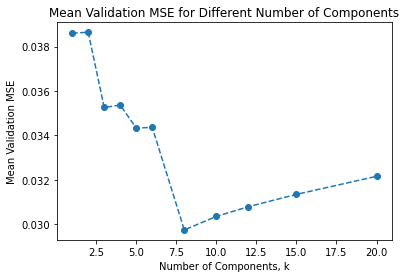

In [14]:
# your code here
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

k_vals = [1,2,3,4,5,6,8,10,12,15,20]

mse_vals = {}

for k in k_vals:
    pca = PCA(n_components = k).fit(X_train)
    X_pca = pca.transform(X_train)
    lreg = LinearRegression()
    mse_score_train = cross_validate(lreg, X_pca, y_train, cv=10, scoring="neg_mean_squared_error", return_train_score=True )
    mse_vals[k] = -1*np.mean(mse_score_train['test_score'])
    
print ("MSE Values: ", mse_vals)
best_k = min(mse_vals, key=mse_vals.get)
print ("\nThe best k is ", best_k)

plt.plot(mse_vals.keys(), mse_vals.values(), "o--")
plt.title("Mean Validation MSE for Different Number of Components")
plt.xlabel("Number of Components, k")
plt.ylabel("Mean Validation MSE")
plt.show()

<div class='exercise-r'>
    

**3.3.2** Now let's compute the $R^2$ value on the testing data:
  - Fit the PCA transformation with n_components equals the best $k$ on the standardized **X_train**.
  - Apply the PCA transformation to the standardized **X_train** and the standardized **X_test**. 
  - Fit a linear regression model to the PCA-transformed components and report the  test $R^2$.
    
</div>

In [15]:
# your code here
# Fit the PCA transformation with n_components equals the best  𝑘  on the standardized X_train.
pca = PCA(n_components = best_k).fit(X_train)

# Apply the PCA transformation to the standardized X_train and the standardized X_test.
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Fit a linear regression model to the PCA-transformed components and report the test  𝑅2 .
lreg = LinearRegression()
lreg.fit(X_train_pca, y_train)
y_pred = lreg.predict(X_test_pca)

# Report R2 values
print(f"The R2 score of the linear regression model of the PCA-transformed components is {r2_score(y_test, y_pred)}")

The R2 score of the linear regression model of the PCA-transformed components is 0.654676981256882


<div class='exercise-r'>

**3.4** Compare the $R^2$ value obtained from **3.2** and **3.3.2**. Interpret the result.
    
</div>

The R2 value has increased from 0.218 to 0.654 after doing a PCA transform. The model has better predictive ability because we have reduced the dimensionality of the feature space, therefore reducing  collinearity. Now through PCA we have created a new set of predictors that capture the maximum amount of variance in the observed data, resulting in a higher R2 value.


<a id="part2q4"></a>

## <div class='exercise'><b> Question 4: Visualizing Transformed Data [10 pts]</b></div>

[Return to contents](#contents)

In this question, we will be using a dataset called "Better Life Index" adapted from [Organisation for Economic Co-operation and Development](https://stats.oecd.org/). The modified dataset contains 24 numerical variables and 1 categorical variable. The categorical variable `Country` is the name of the country. Some of the numerical variables include:

- `Dwellings without basic facilities`
- `Housing expenditure`
- `Rooms per person`
- `Household net adjusted disposable income`
- `Household net financial wealth`
- ...


**Load the dataset, and answer the following questions:**


**4.1** Standardize **X** and apply PCA transformation with n_components = 2 to your standardized data.

**4.2** Make a scatter plot for the transformed data, where the x-axis corresponds to the first principal component, and the y-axis corresponds to the second principal component. Label each point by its corresponding country name. Do you observe any pattern in the scatter plot?

**4.3** In Question 3, where we also used PCA, we had a training and a test set. Here we do not split the data. Explain why.

In [16]:
# Load the datasets
df = pd.read_csv("data/OECD_well-being.csv", index_col = 0)
country, X = df['Country'], df.drop(columns='Country').values
X.shape

(38, 24)

<a id="part2q4solution"></a>
## Question 4: Solutions 

[Return to contents](#contents)

<div class='exercise-r'>

**4.1** Standardize **X** and apply PCA transformation with n_components = 2 to your standardized data.
    
</div>


In [17]:
# your code here
X = StandardScaler().fit_transform(X)

pca = PCA(n_components = 2).fit(X)
X_pca = pca.transform(X)

<div class='exercise-r'>

**4.2** Make a scatter plot for the transformed data, where the x-axis corresponds to the first principal component, and the y-axis corresponds to the second principal component. Label each point by its corresponding country name. Do you observe any pattern in the scatter plot?
    
</div>

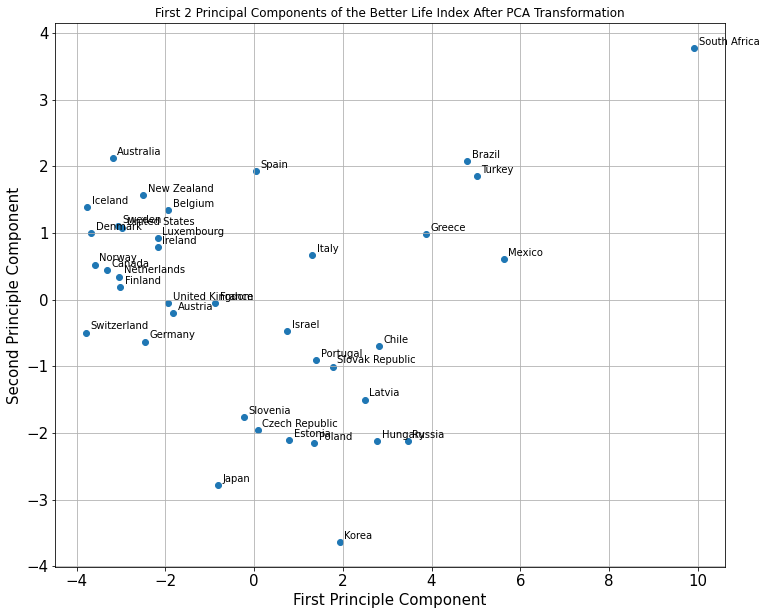

In [18]:
# your code here
fig, ax = plt.subplots()
fig.set_size_inches(12,10)

ax.scatter(X_pca[:,0], X_pca[:,1])

for i, txt in enumerate(country):
    ax.annotate(txt, (X_pca[:,0][i], X_pca[:,1][i]), (X_pca[:,0][i]+0.1, X_pca[:,1][i]+0.05))
    
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('First 2 Principal Components of the Better Life Index After PCA Transformation')
plt.xlabel('First Principle Component', fontsize=15)
plt.ylabel('Second Principle Component', fontsize=15)
plt.grid()
plt.show()

**INTERPRETATION:**

There are patterns within the scatter plot as evidenced by two distinct groupings of data points. The two groupings appear to stick to geographic regions, ie Western Europe and Eastern Europe. Only factors that could be attributed to the groupings are personal earnings, self reported health, quality of support network, and labor market insecurities. These patterns are generic as interpretations of coefficients in PCA are completely lost.

<div class='exercise-r'>

**4.3** In Question 3, where we also used PCA, we had a training and a test set. Here we do not split the data. Explain why.
    
</div>

**INTERPRETATION:**

We do not split the data here because each data point is representative of an entire country and eliminating them before the PCA transformation by splitting the data would significantly bias our results.
